In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch_geometric.nn import GENConv, GATv2Conv, SSGConv
import numpy as np
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import torch_geometric.utils

from tqdm import tqdm

from sklearn.model_selection import KFold
import pandas as pd
from MatrixVectorizer import MatrixVectorizer


In [2]:
# set global variables
N_SUBJECTS = 167

N_LR_NODES = 160

N_HR_NODES = 268

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

N_LR_NODES_F = int(N_LR_NODES * (N_LR_NODES-1) / 2)
N_HR_NODES_F = int(N_HR_NODES * (N_HR_NODES-1) / 2)

In [3]:
from data_preparation import load_data_tensor

lr_train, lr_test, hr_train = load_data_tensor("dgl-icl")

lr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_lr.pt')
lr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_lr_3.pt')
hr_X_dim1 = torch.load('model_autoencoder/final_embeddings/encode_hr.pt')
hr_X_dim3 = torch.load('model_autoencoder/final_embeddings/encode_hr_3.pt')
lr_X_dim1_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test.pt')
hr_X_dim3_test = torch.load('model_autoencoder/final_embeddings/encode_lr_test_3.pt')

# Model Layers

In [4]:
def generate_steps(num_steps, low=N_LR_NODES, high=N_HR_NODES):
    step_size = (high - low) / (num_steps - 1)
    steps_list = [round(low + step_size * i) for i in range(num_steps)]
    return steps_list

In [5]:
class StackedGCN(nn.Module):
    def __init__(self, n_nodes, channel_ls, dropout):
        super().__init__()
        self.n_nodes = n_nodes
        self.gcn_layers, self.batch_norm_layers = self._init_layers(channel_ls)

        # self.gcn_layers, _ = self._init_layers(channel_ls)
        self.dropout = dropout
        
    
    def forward(self, X, A):
        for i in range(len(self.gcn_layers)):
            gcn = self.gcn_layers[i]
            batch_norm = self.batch_norm_layers[i]
            graph_batch = self._create_batch(X, A)
            
            X = F.sigmoid(gcn(graph_batch.x, graph_batch.edge_index, graph_batch.edge_attr).reshape(*X.shape[:2], -1))
            torch.cuda.empty_cache()
            X = F.dropout(batch_norm(X), self.dropout, training=self.training)
            # X = F.dropout(X, self.dropout, training=self.training)
            torch.cuda.empty_cache()

        return X

    def _init_layers(self, channel_ls):
        layers_ls = []
        batch_norm_ls = []
        for i in range(len(channel_ls) - 1):
            layer = GATv2Conv(channel_ls[i], channel_ls[i], heads=2, edge_dim=1)
            layers_ls.append(layer)
            batch_norm_ls.append(torch_geometric.nn.norm.BatchNorm(self.n_nodes))
        return nn.ModuleList(layers_ls), nn.ModuleList(batch_norm_ls)

    def _create_batch(self, X, A):
        data_list = []
        for x, adj in zip(X, A):
            edge_index = adj.nonzero().t()
            edge_weights = adj[edge_index[0], edge_index[1]]
            edge_index, edge_weights = torch_geometric.utils.add_self_loops(edge_index, edge_weights) # add self connections
            data = Data(x=x, edge_index=edge_index, edge_attr=edge_weights.view(-1, 1))
            data_list.append(data)
        return torch_geometric.data.Batch().from_data_list(data_list)

In [6]:
class AdjacencyStep(nn.Module):
    def __init__(self, old_dim, new_dim, channels_ls, dt=1., alpha=0.9, gamma=0.9, dropout=0.25):
        super().__init__()
        self.dt = dt
        self.alpha = alpha
        self.gamma = gamma
        self.gnn = StackedGCN(old_dim, channels_ls, dropout).to(DEVICE)
        self.dropout = dropout
        # self.dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))
        # self.dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))

        self.A_dim_changer = nn.Parameter(torch.randn((new_dim, old_dim), device=DEVICE))
        # self.A_dim_changer1 = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))   
        # self.A_dim_changer2 = nn.Parameter(torch.randn((1, old_dim), device=DEVICE))
        self.A_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_changer = nn.Parameter(torch.randn((channels_ls[-1], new_dim), device=DEVICE))
        # self.Z_dim_changer1 = nn.Parameter(torch.randn((channels_ls[-1], 1), device=DEVICE))   
        # self.Z_dim_changer2 = nn.Parameter(torch.randn((1, new_dim), device=DEVICE))
        self.Z_dim_bias = nn.Parameter(torch.randn((new_dim, 1), device=DEVICE))

        self.Z_dim_lower = nn.Conv1d(channels_ls[-1], channels_ls[0], kernel_size=1)


        self.forget_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))
        self.input_gate = nn.Parameter(torch.randn(new_dim, device=DEVICE))

        self.batchnorm_A = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.layernorm_forget_A = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.layernorm_input_Z = torch_geometric.nn.norm.LayerNorm((new_dim, new_dim))
        self.batchnorm_X = torch_geometric.nn.norm.BatchNorm(new_dim)
        self.batchnorm_Y = torch_geometric.nn.norm.BatchNorm(new_dim)



    def forward(self, X, Y, A):
        # solve ODEs using simple IMEX scheme
        # dim_changer = self.dim_changer1 @ self.dim_changer2 
        # A_dim_changer = self.A_dim_changer1 @ self.A_dim_changer2
        # Z_dim_changer = self.Z_dim_changer1 @ self.Z_dim_changer2
        dim_changer = self.dim_changer
        A_dim_changer = self.A_dim_changer
        Z_dim_changer = self.Z_dim_changer

        # forget gate from previous adjacency
        f = F.sigmoid(self.forget_gate)
        i = F.sigmoid(self.input_gate)
        forget_A = F.elu(A_dim_changer @ A @ A_dim_changer.T + self.A_dim_bias)
        forget_A = f[:, None] * self.layernorm_forget_A(forget_A)
        # forget_A = f[:, None] * forget_A
        torch.cuda.empty_cache()

    
        # update node features with gcn
        Z = self.gnn(X, A)
        torch.cuda.empty_cache()
        input_Z = F.elu(dim_changer @ Z @ Z_dim_changer + self.Z_dim_bias)
        input_Z = i[:, None] * self.layernorm_input_Z(input_Z)
        # input_Z = i[:, None] * input_Z
        torch.cuda.empty_cache()



        # get new adjacency matrix
        new_A = forget_A + input_Z
        new_A = self.batchnorm_A(new_A)
        new_A = (new_A + torch.transpose(new_A, -1, -2)) / 2
        new_A = F.tanh(F.relu(new_A))
        # new_A = F.hardtanh(F.hardtanh(new_A, min_val=0), min_val=0)


        torch.cuda.empty_cache()


        # update feature embeiddings
        Z = torch.transpose(self.Z_dim_lower(torch.transpose(Z, -1, -2)), -1, -2)
        Y_temp = Y
        Y = dim_changer @ (Y + self.dt * (Z - self.alpha * Y - self.gamma * X))
        X = dim_changer @ (X + self.dt * Y_temp) 

        X = self.batchnorm_X(X)
        Y = self.batchnorm_Y(Y)   
        torch.cuda.empty_cache()


        Y = F.dropout(Y, self.dropout, training=self.training)
        X = F.dropout(X, self.dropout, training=self.training)

        return X, Y, new_A

    

In [7]:
class AdjacencyDimChanger(nn.Module):

    def __init__(self, dim_steps, channels_ls):
        super().__init__()
        
        self.layers = nn.ModuleList([AdjacencyStep(dim_steps[i], dim_steps[i+1], channels_ls) for i in range(len(dim_steps)-1)])
        # self.batchnorms = nn.ModuleList([nn.BatchNorm1d(dim_steps[i+1]) for i in range(len(dim_steps)-1)])
        
    def forward(self, X, Y, A):
        adj_ls = [A]
        x, y, adj = X, Y, A
        
        for layer in self.layers:
            x, y, adj = layer(x, y, adj)
            adj_ls.append(adj)
            
        return adj_ls
        

In [8]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [9]:
import numpy as np
import networkx as nx

def eigen_centrality(data):
    # ROI is the number of brain regions (i.e.,35 in our case)
    ROI = 160

    topology_eigen = []

    G = nx.from_numpy_array(np.absolute(data))
    U = G.to_undirected()

    # A = to_2d(data)
    np.fill_diagonal(data, 0)

    # create a graph frL2
    # # compute egeinvector centrality and transform the output to vector
    ec = nx.eigenvector_centrality_numpy(U)
    
    eigenvector_centrality = np.array([ec[g] for g in U])



    topology_eigen.append(eigenvector_centrality)  # 2

    return topology_eigen

def pearson_coor(input, target, epsilon=1e-7):
    vx = input - torch.mean(input, dim=(1, 2))[:, None, None]
    vy = target - torch.mean(target, dim=(1, 2))[:, None, None]
    cost = torch.sum(vx * vy) / (torch.sqrt(torch.sum(vx ** 2)+epsilon) * torch.sqrt(torch.sum(vy ** 2)+epsilon)+epsilon)
    return cost

def GT_loss(target, predicted):

    # l1_loss
    l1_loss = torch.nn.L1Loss()
    # loss_pix2pix = l1_loss(target, predicted)

    # topological_loss
    target_n = target.detach().cpu().clone().numpy()
    predicted_n = predicted.detach().cpu().clone().numpy()
    torch.cuda.empty_cache()

    topo_loss = []
    

    for i in range(len(target_n)):

        cur_target = target_n[i]
        cur_predicted = predicted_n[i]

        target_t = eigen_centrality(cur_target)
        real_topology = torch.tensor(target_t[0])
        predicted_t = eigen_centrality(cur_predicted)
        fake_topology = torch.tensor(predicted_t[0])
        topo_loss.append(l1_loss(real_topology, fake_topology))

    topo_loss = torch.sum(torch.stack(topo_loss))

    pc_loss = pearson_coor(target, predicted).to(DEVICE)
    torch.cuda.empty_cache()

    # G_loss = loss_pix2pix + (1 - pc_loss) + topo_loss
    G_loss = (1 - pc_loss) + topo_loss


    return G_loss

In [10]:
def loss_calc(adj_ls, opp_adj_ls, alpha=0.75, weights=None):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = opp_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    if weights is None:
        n = len(adj_ls[1:-1])
        weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (adj, opp_adj) in enumerate(zip(adj_ls[:-1], opp_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(adj, opp_adj)

    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss
    # total_loss = total_loss + alpha * final_mse_loss * (1 + intermediate_mse_loss) * (gamma ** 2)
    # total_loss = total_loss + (1-alpha) * intermediate_mse_loss * (beta ** 2)
        

    # gt_loss = torch.Tensor([0]).to(DEVICE)
    # for i, (adj, opp_adj) in enumerate(zip(adj_ls, opp_adj_ls[::-1])):

    #     ### NOTE TEMPORARY MEASURE BECAUSE THEY TAKE IN (BATCHSIZE, xx, xx) shape ####
    #     temp_adj = adj.reshape(1, *adj.shape)
    #     temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    #     ##########################################################
    #     gt_loss = gt_loss + GT_loss(temp_adj, temp_opp_adj)

    # gt_loss = gt_loss / n
        
    return total_loss

def up_loss_fn(up_adj_ls, down_adj_ls, alpha, epoch_weight):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    # calculate the loss for the upper traingle of the matrix because thats what we care about
    final_dim = up_adj_ls[-1].shape[-1]
    upper_tri_idx = torch.triu_indices(final_dim, final_dim, offset=1)
    final_upper_tri_adj = up_adj_ls[-1][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_upper_tri_other_adj = down_adj_ls[0][:,upper_tri_idx.unbind()[0], upper_tri_idx.unbind()[1]]
    final_mse_loss = mse_loss_fn(final_upper_tri_adj, final_upper_tri_other_adj)

    n = len(up_adj_ls[:-1])
    weights = torch.Tensor([2*(i+1)/(n*(n+1)) for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    intermediate_mse_loss = torch.Tensor([0]).to(DEVICE)
    for i, (up_adj, down_adj) in enumerate(zip(up_adj_ls[:-1], down_adj_ls[1:][::-1])):
        intermediate_mse_loss = intermediate_mse_loss + weights[i] * mse_loss_fn(up_adj, down_adj)


    total_loss = total_loss + alpha * final_mse_loss + (1-alpha) * intermediate_mse_loss * epoch_weight
    return total_loss

def down_loss_fn(down_adj_ls, up_adj_ls):
    total_loss = torch.Tensor([0]).to(DEVICE)
    mse_loss_fn = nn.MSELoss()

    n = len(down_adj_ls[:])
    weights = torch.Tensor([1/n for i in range(n)])
    
    # calculate the loss for the remaining intermediate adjacent matrices
    for i, (down_adj, up_adj) in enumerate(zip(down_adj_ls[:], up_adj_ls[::-1])):
        total_loss = total_loss + weights[i] * mse_loss_fn(down_adj, up_adj)

    return total_loss
    
def reconstruction_loss_fn(gt_adj, pred_adj):
    l1_loss_fn = nn.L1Loss()
    return l1_loss_fn(gt_adj, pred_adj)

def end_adj_loss_calc(adj, opp_adj):
    mae_loss_fn = torch.nn.L1Loss()
    n = len(adj)
    upper_tri_idx = torch.triu_indices(n, n, offset=1)
    upper_tri_adj = adj.detach()[upper_tri_idx.unbind()]
    upper_tri_opp_adj = opp_adj.detach()[upper_tri_idx.unbind()]
    mae_loss = mae_loss_fn(upper_tri_adj, upper_tri_opp_adj)
    # temp_adj = adj.reshape(1, *adj.shape)
    # temp_opp_adj = opp_adj.reshape(1, *opp_adj.shape)
    # gt_loss = GT_loss(temp_adj, temp_opp_adj)
    return mae_loss.detach().item()

# Training

In [11]:
trainloader = DataLoader(list(zip(lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train)), shuffle=True, batch_size=16)
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=32)

dim_steps = generate_steps(num_steps=12)
channels_ls = [32, 64]

up_changer = AdjacencyDimChanger(dim_steps, channels_ls).to(DEVICE)
down_changer = AdjacencyDimChanger(dim_steps[::-1], channels_ls).to(DEVICE)

up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.0025, betas=(0.5, 0.999))
reconstruction_optimizer = torch.optim.AdamW(list(up_changer.parameters()) + list(down_changer.parameters()), lr=0.0025, betas=(0.5, 0.999))

sum(p.numel() for model in [up_changer, down_changer] for p in model.parameters())


6673868

In [12]:
import gc

def train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, completed_epochs=0, loss_log=None):

    if loss_log is None:
        loss_log = {'up': [], 'down': [], 'up_end_mae':[], 'down_end_mae':[]}

    up_changer.train()
    down_changer.train()   

    epoch_weight = 1
    for epoch in range(epochs):

        up_losses = []
        up_final_mae_ls = []
        down_final_mae_ls = []
        down_losses = []
        reconstruction_losses = []
            
        if (epoch + 1) % 10 == 0:
            epoch_weight = 1 / (2 ** (0.8 * (epoch + completed_epochs + 1)))


        for X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr in tqdm(trainloader):
            gc.collect()
            freeze_model(up_changer)
            unfreeze_model(down_changer)
        
            down_optimizer.zero_grad()

            
            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()

            down_loss = down_loss_fn(down_adj_ls[1:], up_adj_ls[:-1])
        
            # for printing loss only
            down_final_mae_ls.append(end_adj_loss_calc(down_adj_ls[-1].detach(), up_adj_ls[0].detach()))
            torch.cuda.empty_cache()
            
            # del down_end_adj_gt_loss
            down_loss.backward()
            down_optimizer.step()

            down_losses.append(down_loss.detach().item())
            del down_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            freeze_model(down_changer)
        
            up_optimizer.zero_grad()

            up_adj_ls = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))
            torch.cuda.empty_cache()
            down_adj_ls = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))
            torch.cuda.empty_cache()
        
            up_loss = up_loss_fn(up_adj_ls[1:], down_adj_ls[:-1], alpha=0.75, epoch_weight=epoch_weight)
            
            # for printing loss only
            up_final_mae_ls.append(end_adj_loss_calc(up_adj_ls[-1].detach(), down_adj_ls[0].detach()))
            torch.cuda.empty_cache()

            
            up_loss.backward()
            up_optimizer.step()

            up_losses.append(up_loss.detach().item())
            del up_loss
            torch.cuda.empty_cache()

            unfreeze_model(up_changer)
            unfreeze_model(down_changer)

            reconstruction_optimizer.zero_grad()

            down_adj_end = down_changer(X_hr.to(DEVICE), Y_hr.to(DEVICE), adj_hr.to(DEVICE))[-1]
            torch.cuda.empty_cache()

            up_adj_end = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), down_adj_ls[-1])[-1]
            torch.cuda.empty_cache()

            reconstruction_loss = reconstruction_loss_fn(up_adj_end, adj_hr.to(DEVICE))
            reconstruction_loss.backward()
            reconstruction_optimizer.step()
            torch.cuda.empty_cache()

        
            reconstruction_losses.append(reconstruction_loss.detach().item())
            del reconstruction_loss
            torch.cuda.empty_cache()

        
        epoch_up_loss = np.mean(up_losses)
        epoch_down_loss = np.mean(down_losses)
        epoch_reconstruction_loss = np.mean(reconstruction_losses)
        epoch_up_final_mae = np.mean(up_final_mae_ls)
        epoch_down_final_mae = np.mean(down_final_mae_ls)
        
        loss_log['up'].append(epoch_up_loss)
        loss_log['down'].append(epoch_down_loss)
        loss_log['up_end_mae'].append(epoch_up_final_mae)
        loss_log['down_end_mae'].append(epoch_down_final_mae)

        print(f'ep {epoch}: down loss = {epoch_down_loss}, up loss = {epoch_up_loss}, reconst.loss = {epoch_reconstruction_loss}, down adj mae = {epoch_down_final_mae}, up adj mae = {epoch_up_final_mae}')


    return up_changer, down_changer, loss_log


In [13]:
gc.collect()
up_changer, down_changer, loss_log = train(200, up_changer, down_changer, trainloader, up_optimizer, down_optimizer, completed_epochs=0, loss_log=None)

100%|██████████| 11/11 [00:22<00:00,  2.03s/it]


ep 0: down loss = 0.19565032422542572, up loss = 0.15023772553964096, reconst.loss = 0.2808538485657085, down adj mae = 0.2586880854584954, up adj mae = 0.28874450651082123


100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


ep 1: down loss = 0.16343759406696667, up loss = 0.12074285610155626, reconst.loss = 0.24453130228952927, down adj mae = 0.2386215396902778, up adj mae = 0.26138207045468415


100%|██████████| 11/11 [00:19<00:00,  1.80s/it]


ep 2: down loss = 0.15230515599250793, up loss = 0.10448252680626782, reconst.loss = 0.22025027871131897, down adj mae = 0.2207829843867909, up adj mae = 0.22590356252410196


100%|██████████| 11/11 [00:19<00:00,  1.76s/it]


ep 3: down loss = 0.14425126937302676, up loss = 0.09391878748481924, reconst.loss = 0.20254754478281195, down adj mae = 0.21218456327915192, up adj mae = 0.21055971086025238


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 4: down loss = 0.13034955818544736, up loss = 0.07898092879490419, reconst.loss = 0.18188065425916153, down adj mae = 0.20468326183882626, up adj mae = 0.1909351430156014


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 5: down loss = 0.11510880833322351, up loss = 0.07154636152765968, reconst.loss = 0.1729053191163323, down adj mae = 0.19997055422176013, up adj mae = 0.18654896996238016


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 6: down loss = 0.10321936282244595, up loss = 0.06487529961900278, reconst.loss = 0.16614394160834225, down adj mae = 0.1865433630618182, up adj mae = 0.17667697776447644


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 7: down loss = 0.09620376269925725, up loss = 0.05980237471786412, reconst.loss = 0.16175240142778916, down adj mae = 0.17839520492336966, up adj mae = 0.16890567947517743


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 8: down loss = 0.09039505367929285, up loss = 0.055583484809507026, reconst.loss = 0.15762316503308035, down adj mae = 0.1742188117720864, up adj mae = 0.16264492544260892


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 9: down loss = 0.0804266706109047, up loss = 0.031850950623100456, reconst.loss = 0.15192750638181513, down adj mae = 0.17159417136148972, up adj mae = 0.1599247631701556


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 10: down loss = 0.07609266550703482, up loss = 0.03134921684183858, reconst.loss = 0.15154601633548737, down adj mae = 0.1638843999667601, up adj mae = 0.15765586224469272


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 11: down loss = 0.07836626131426204, up loss = 0.02921059812334451, reconst.loss = 0.14821010286157782, down adj mae = 0.16580149260434238, up adj mae = 0.15192954377694565


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 12: down loss = 0.07392159070480954, up loss = 0.028721637685190548, reconst.loss = 0.14729181744835593, down adj mae = 0.16159439899704672, up adj mae = 0.15013663470745087


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 13: down loss = 0.07080133868889375, up loss = 0.029728626324371857, reconst.loss = 0.14636083353649487, down adj mae = 0.15707855197516354, up adj mae = 0.15222345157103104


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 14: down loss = 0.06711474602872675, up loss = 0.02760239080949263, reconst.loss = 0.14485371654683893, down adj mae = 0.1535615406253121, up adj mae = 0.14978193017569455


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 15: down loss = 0.0629972636022351, up loss = 0.026762353764338928, reconst.loss = 0.14207390763542868, down adj mae = 0.15461649136109787, up adj mae = 0.14708370376716962


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 16: down loss = 0.06308397142724557, up loss = 0.027004590596665035, reconst.loss = 0.1430913440205834, down adj mae = 0.15416746789758856, up adj mae = 0.1466324044899507


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 17: down loss = 0.06048277122053233, up loss = 0.027168545533310284, reconst.loss = 0.1436637355522676, down adj mae = 0.14965066449208694, up adj mae = 0.1469670615412972


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 18: down loss = 0.06372895362702283, up loss = 0.0277764191004363, reconst.loss = 0.14430456405336206, down adj mae = 0.15364016592502594, up adj mae = 0.1506448428739201


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 19: down loss = 0.06052861362695694, up loss = 0.02674642171372067, reconst.loss = 0.1421519707549702, down adj mae = 0.1498869007283991, up adj mae = 0.14525977996262637


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 20: down loss = 0.061572063375603066, up loss = 0.02751921574500474, reconst.loss = 0.14396389777010138, down adj mae = 0.14789395169778305, up adj mae = 0.14656825770031323


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 21: down loss = 0.057938063009218735, up loss = 0.02626694586466659, reconst.loss = 0.14209769395264712, down adj mae = 0.1461418799378655, up adj mae = 0.14435011961243369


100%|██████████| 11/11 [00:17<00:00,  1.59s/it]


ep 22: down loss = 0.05583880266005343, up loss = 0.026802854781801052, reconst.loss = 0.14296766302802347, down adj mae = 0.14865931462157855, up adj mae = 0.14523772759871048


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 23: down loss = 0.0543468255888332, up loss = 0.02642851136624813, reconst.loss = 0.1419602930545807, down adj mae = 0.1470325602726503, up adj mae = 0.14503814009102908


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 24: down loss = 0.05380874398079785, up loss = 0.02645074406808073, reconst.loss = 0.14137866686690936, down adj mae = 0.14517151361162012, up adj mae = 0.14373572035269302


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 25: down loss = 0.055496385490352455, up loss = 0.025952774354002693, reconst.loss = 0.14106339080767197, down adj mae = 0.14953904124823483, up adj mae = 0.14347204566001892


100%|██████████| 11/11 [00:16<00:00,  1.53s/it]


ep 26: down loss = 0.05267169868404215, up loss = 0.025716400959274986, reconst.loss = 0.13945418731732803, down adj mae = 0.143715193325823, up adj mae = 0.141320448030125


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 27: down loss = 0.05163545703346079, up loss = 0.025277795778079468, reconst.loss = 0.13936934958804736, down adj mae = 0.14575779844414105, up adj mae = 0.14353913475166669


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 28: down loss = 0.05034131793813272, up loss = 0.02475934644991701, reconst.loss = 0.13929289850321683, down adj mae = 0.14570083672350104, up adj mae = 0.14008098163387991


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 29: down loss = 0.050613563169132576, up loss = 0.024612540379166603, reconst.loss = 0.13852459192276, down adj mae = 0.14318472011522812, up adj mae = 0.137917314063419


100%|██████████| 11/11 [00:17<00:00,  1.55s/it]


ep 30: down loss = 0.0498301816934889, up loss = 0.024454399435357613, reconst.loss = 0.13719728724523025, down adj mae = 0.14026373353871432, up adj mae = 0.13824963163245807


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 31: down loss = 0.05039952153509313, up loss = 0.024435165253552524, reconst.loss = 0.13720646771517667, down adj mae = 0.1405834840102629, up adj mae = 0.13859167153185065


100%|██████████| 11/11 [00:16<00:00,  1.54s/it]


ep 32: down loss = 0.05290858515284278, up loss = 0.025801642374558884, reconst.loss = 0.13876439360055057, down adj mae = 0.14120563187382437, up adj mae = 0.13780101050030102


100%|██████████| 11/11 [00:17<00:00,  1.56s/it]


ep 33: down loss = 0.05595073137771, up loss = 0.02935599061575803, reconst.loss = 0.14260319552638315, down adj mae = 0.14482104100964285, up adj mae = 0.14849932898174634


100%|██████████| 11/11 [00:16<00:00,  1.55s/it]


ep 34: down loss = 0.05453034219416705, up loss = 0.02473268454725092, reconst.loss = 0.13879453458569266, down adj mae = 0.1402554132721641, up adj mae = 0.14050132848999716


100%|██████████| 11/11 [00:17<00:00,  1.57s/it]


ep 35: down loss = 0.05297125740484758, up loss = 0.02434966696256941, reconst.loss = 0.13685849038037387, down adj mae = 0.13930469209497626, up adj mae = 0.14014196395874023


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 36: down loss = 0.05192421478303996, up loss = 0.026197331703521988, reconst.loss = 0.1430184759876945, down adj mae = 0.14209004152904858, up adj mae = 0.14361398870294745


100%|██████████| 11/11 [00:17<00:00,  1.60s/it]


ep 37: down loss = 0.050313963131471115, up loss = 0.024556607685305855, reconst.loss = 0.13793094049800525, down adj mae = 0.13893473012880844, up adj mae = 0.1376594833352349


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 38: down loss = 0.04991229555823586, up loss = 0.024254872378977863, reconst.loss = 0.13698372515765103, down adj mae = 0.14530788632956418, up adj mae = 0.13967018506743692


100%|██████████| 11/11 [00:17<00:00,  1.62s/it]


ep 39: down loss = 0.049660786309025505, up loss = 0.0238380300050432, reconst.loss = 0.13604007796807724, down adj mae = 0.14229132776910608, up adj mae = 0.13911417397585782


100%|██████████| 11/11 [00:17<00:00,  1.61s/it]


ep 40: down loss = 0.04941763220862909, up loss = 0.024048123847354542, reconst.loss = 0.1365034742788835, down adj mae = 0.1402050649577921, up adj mae = 0.13619877939874475


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 41: down loss = 0.046430804512717506, up loss = 0.023992002857002346, reconst.loss = 0.13544816726988013, down adj mae = 0.1388393207029863, up adj mae = 0.13604278997941452


100%|██████████| 11/11 [00:18<00:00,  1.64s/it]


ep 42: down loss = 0.04783393002369187, up loss = 0.024646643379872494, reconst.loss = 0.13661166348240592, down adj mae = 0.14007833735509354, up adj mae = 0.13961363651535727


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 43: down loss = 0.04485283656553789, up loss = 0.02490556968206709, reconst.loss = 0.137238778851249, down adj mae = 0.13674602860754187, up adj mae = 0.13738305324857886


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 44: down loss = 0.04458544301715764, up loss = 0.02413071421059695, reconst.loss = 0.13586815107952466, down adj mae = 0.13923630660230463, up adj mae = 0.13463933765888214


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 45: down loss = 0.04386123235930096, up loss = 0.02338628928092393, reconst.loss = 0.1349782022562894, down adj mae = 0.1352725015445189, up adj mae = 0.13427057591351596


100%|██████████| 11/11 [00:18<00:00,  1.71s/it]


ep 46: down loss = 0.04217467490922321, up loss = 0.023000564087520946, reconst.loss = 0.13373623517426578, down adj mae = 0.13714966042475266, up adj mae = 0.13470287079160864


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 47: down loss = 0.04338950731537559, up loss = 0.023437937213615936, reconst.loss = 0.1344694955782457, down adj mae = 0.13523583859205246, up adj mae = 0.13549422134052624


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 48: down loss = 0.04437955807555805, up loss = 0.02357747033238411, reconst.loss = 0.1355272815986113, down adj mae = 0.1398694014007395, up adj mae = 0.136341162703254


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 49: down loss = 0.042481374334205284, up loss = 0.023105819286270576, reconst.loss = 0.13391065868464383, down adj mae = 0.13489568504420194, up adj mae = 0.13344118270007047


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 50: down loss = 0.042978059500455856, up loss = 0.02287807163189758, reconst.loss = 0.13410124724561517, down adj mae = 0.13796184144236825, up adj mae = 0.1361934312365272


100%|██████████| 11/11 [00:17<00:00,  1.63s/it]


ep 51: down loss = 0.040664581073956055, up loss = 0.02268313616514206, reconst.loss = 0.13256993347948248, down adj mae = 0.13604919612407684, up adj mae = 0.13558924401348288


100%|██████████| 11/11 [00:18<00:00,  1.66s/it]


ep 52: down loss = 0.04076868735931136, up loss = 0.0229079510000619, reconst.loss = 0.13350402360612695, down adj mae = 0.13612189211628653, up adj mae = 0.1356023441661488


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 53: down loss = 0.040897701951590454, up loss = 0.023080212995409966, reconst.loss = 0.13406392119147562, down adj mae = 0.13590487905523993, up adj mae = 0.13529864156788046


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 54: down loss = 0.041376997462727806, up loss = 0.023117825050245632, reconst.loss = 0.13470142537897284, down adj mae = 0.13762786848978562, up adj mae = 0.1362078474326567


100%|██████████| 11/11 [00:18<00:00,  1.65s/it]


ep 55: down loss = 0.04586961797692559, up loss = 0.023610266264189373, reconst.loss = 0.1350741765715859, down adj mae = 0.13725192709402603, up adj mae = 0.1378273679451509


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 56: down loss = 0.0420542796227065, up loss = 0.022709395736455917, reconst.loss = 0.1325589120388031, down adj mae = 0.13951987569982355, up adj mae = 0.13757469776001843


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 57: down loss = 0.04168314825404774, up loss = 0.02279757809909907, reconst.loss = 0.1335372884165157, down adj mae = 0.13406433436003598, up adj mae = 0.13378091021017594


100%|██████████| 11/11 [00:18<00:00,  1.68s/it]


ep 58: down loss = 0.04209590838714079, up loss = 0.022631205110387367, reconst.loss = 0.13372533294287595, down adj mae = 0.13479184833439914, up adj mae = 0.13459664583206177


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 59: down loss = 0.0424661555073478, up loss = 0.022847567600282757, reconst.loss = 0.1334772069345821, down adj mae = 0.13306296752257782, up adj mae = 0.13316988267681815


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 60: down loss = 0.04107377034696666, up loss = 0.022507081654938785, reconst.loss = 0.13318665732036938, down adj mae = 0.1351310502399098, up adj mae = 0.13187605278058487


100%|██████████| 11/11 [00:18<00:00,  1.67s/it]


ep 61: down loss = 0.04150276360186664, up loss = 0.02284757454286922, reconst.loss = 0.13268990137360312, down adj mae = 0.13667527518489145, up adj mae = 0.13564708557995883


100%|██████████| 11/11 [00:18<00:00,  1.69s/it]


ep 62: down loss = 0.04057387838309461, up loss = 0.02267848395488479, reconst.loss = 0.1328319636258212, down adj mae = 0.13932972198182886, up adj mae = 0.13471563837744974


100%|██████████| 11/11 [00:18<00:00,  1.72s/it]


ep 63: down loss = 0.041600778698921204, up loss = 0.022881634533405304, reconst.loss = 0.1332154409451918, down adj mae = 0.1369778500361876, up adj mae = 0.13590679249980234


100%|██████████| 11/11 [00:19<00:00,  1.73s/it]


ep 64: down loss = 0.04073435135863044, up loss = 0.022207217968323013, reconst.loss = 0.13210742311044174, down adj mae = 0.1400740539485758, up adj mae = 0.13423669744621625


100%|██████████| 11/11 [00:19<00:00,  1.75s/it]


ep 65: down loss = 0.041123694655570114, up loss = 0.022761288352987984, reconst.loss = 0.13229379870674826, down adj mae = 0.1365725641900843, up adj mae = 0.1349803696979176


100%|██████████| 11/11 [00:18<00:00,  1.70s/it]


ep 66: down loss = 0.0405472188510678, up loss = 0.022940910336646168, reconst.loss = 0.13353869183496994, down adj mae = 0.13573960824446243, up adj mae = 0.13490266285159372


100%|██████████| 11/11 [00:19<00:00,  1.74s/it]


ep 67: down loss = 0.04053028571334752, up loss = 0.022230777381495995, reconst.loss = 0.1320356699553403, down adj mae = 0.1373885070735758, up adj mae = 0.13580491867932407


  9%|▉         | 1/11 [00:01<00:17,  1.76s/it]

In [19]:
min(loss_log['up_end_mae'])

NameError: name 'loss_log' is not defined

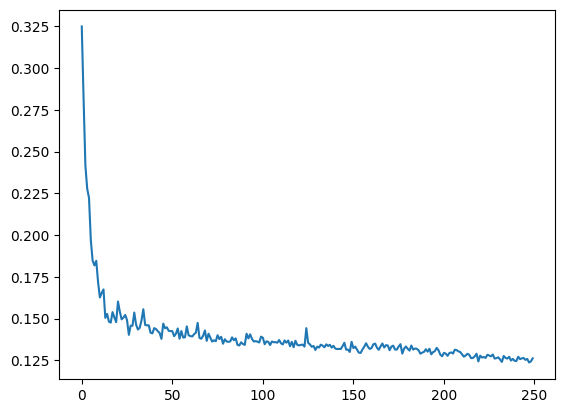

In [27]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(loss_log['up_end_mae'])), loss_log['up_end_mae'])
plt.show()

In [28]:
torch.save(up_changer.state_dict(), 'submission_files/submitme.pth')

In [17]:
# to generate test predictions
testloader = DataLoader(list(zip(lr_X_dim1_test, lr_X_dim3, lr_test)), shuffle=True, batch_size=16)

up_changer.eval()
test_predictions = []
for X_lr, Y_lr, adj_lr in tqdm(testloader):
    pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
    test_predictions.append(pred)
test_predictions = torch.cat(test_predictions)

100%|██████████| 7/7 [00:01<00:00,  4.96it/s]


In [30]:
torch.save(test_predictions, 'submission_files/tim_deep3_reconstr/tim_deep3_reconstr_pred250.pt')

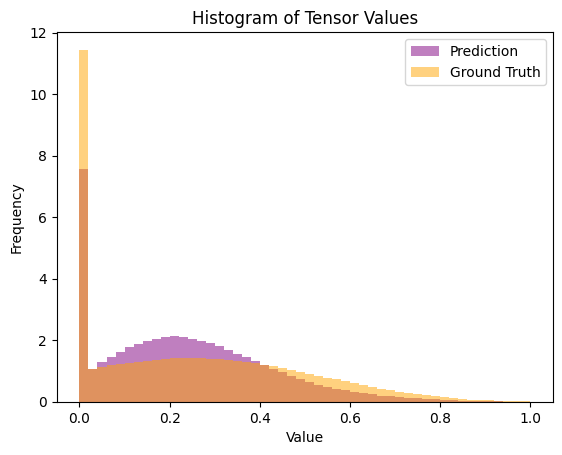

In [20]:
from data_preparation import generate_histogram
generate_histogram(test_predictions.cpu(), hr_train)

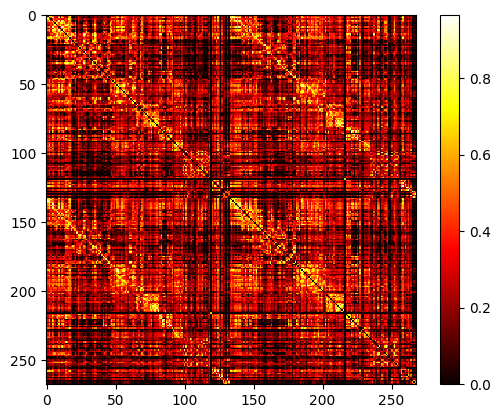

In [21]:
from data_preparation import generate_heatmap
generate_heatmap(test_predictions[0].cpu())

In [18]:
from data_preparation import generate_submission_file

df = generate_submission_file(test_predictions.cpu(), 'submission_files/submitme.csv')

# Cross Validation

In [11]:
from evaluation_fn import evaluate_predictions

def validation(up_changer, testloader, val_adj_hr):
    print('begin validation')
    up_changer.eval()

    val_predictions = []
    for X_lr, Y_lr, adj_lr in tqdm(testloader):
        pred = up_changer(X_lr.to(DEVICE), Y_lr.to(DEVICE), adj_lr.to(DEVICE))[-1].detach()
        val_predictions.append(pred)
    val_predictions = torch.cat(val_predictions)

    return evaluate_predictions(val_predictions, val_adj_hr)

In [12]:
def cross_validate(epochs, batch_size, n_fold, X_lr, Y_lr, adj_lr, X_hr, Y_hr, adj_hr, num_steps, f=32):
    kf = KFold(n_fold, shuffle=True, random_state=99)
    runs_results = []
    for train_idx, val_idx in kf.split(X_lr):
        train_X_lr, val_X_lr = X_lr[train_idx], X_lr[val_idx]
        train_Y_lr, val_Y_lr = Y_lr[train_idx], Y_lr[val_idx]
        train_adj_lr, val_adj_lr = adj_lr[train_idx], adj_lr[val_idx]
        train_X_hr = X_hr[train_idx]
        train_Y_hr = Y_hr[train_idx]
        train_adj_hr, val_adj_hr = adj_hr[train_idx], adj_hr[val_idx]

        trainloader = DataLoader(list(zip(train_X_lr, train_Y_lr, train_adj_lr, train_X_hr, train_Y_hr, train_adj_hr)), shuffle=True, batch_size=batch_size)

        dim_steps = generate_steps(num_steps=10)

        up_changer = AdjacencyDimChanger(dim_steps, f=f).to(DEVICE)
        down_changer = AdjacencyDimChanger(dim_steps[::-1], f=f).to(DEVICE)

        up_optimizer = torch.optim.AdamW(up_changer.parameters(), lr=0.001, betas=(0.5, 0.999))
        down_optimizer = torch.optim.AdamW(down_changer.parameters(), lr=0.001, betas=(0.5, 0.999))    
        
        up_changer, down_changer, _ = train(epochs, up_changer, down_changer, trainloader, up_optimizer, down_optimizer)

        testloader = DataLoader(list(zip(val_X_lr, val_Y_lr, val_adj_lr)), shuffle=True, batch_size=batch_size)
        val_metrics = validation(up_changer, testloader, val_adj_hr)
        runs_results.append(val_metrics)

    return runs_results

In [15]:
cross_validate(5, 32, 3, lr_X_dim1, lr_X_dim3, lr_train, hr_X_dim1, hr_X_dim3, hr_train, num_steps=10)

100%|██████████| 4/4 [00:05<00:00,  1.46s/it]


epoch 0: down loss = 0.16564956307411194, up loss = 0.17200086265802383
Down end adj mae 0.28989551216363907
Up end adj mae 0.30541523545980453


100%|██████████| 4/4 [00:04<00:00,  1.23s/it]


epoch 1: down loss = 0.1615280844271183, up loss = 0.16848218068480492
Down end adj mae 0.2799903079867363
Up end adj mae 0.29920385777950287


100%|██████████| 4/4 [00:04<00:00,  1.22s/it]


epoch 2: down loss = 0.1559770405292511, up loss = 0.16499020531773567
Down end adj mae 0.27102500945329666
Up end adj mae 0.29710303246974945


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 3: down loss = 0.15054432675242424, up loss = 0.16159073635935783
Down end adj mae 0.2658237814903259
Up end adj mae 0.28980008512735367


100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


epoch 4: down loss = 0.14580555632710457, up loss = 0.15819920599460602
Down end adj mae 0.24981610849499702
Up end adj mae 0.2819031700491905
begin validation


100%|██████████| 2/2 [00:00<00:00,  4.53it/s]
